In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import re
from pathlib import Path
from typing import Final, TypeAlias

import numpy as np
import pandas as pd
import shap
from IPython.display import display
from matplotlib import pyplot as plt
from shap import Explainer

from authorship_tool.types_ import AuthorCollection, Doc3dStr, Para2dStr, Tag
from authorship_tool.util import text_reader
from authorship_tool.util.dim_reshaper import reduce_dim
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import cv_trainer, trainer
from authorship_tool.util.ml.model import (
    CrossValidationResult,
    CvGlobalExplanationData,
    LGBMSource,
    Score,
    TrainingResult,
    dump,
    pred_crosstab,
)
from authorship_tool.util.path_util import (
    DatasetPaths,
    VijiniDatasetLoocvPaths,
    VijiniDatasetPaths,
)
from authorship_tool.util.serializer import author_collection_to_csv
from authorship_tool.util.tokenizer import tokenize_para

In [7]:
fully_generated_dataset_path: Final[Path] = DatasetPaths.vijini_dataset_fully_gen
hybrid_dataset_path: Final[Path] = DatasetPaths.vijini_dataset_hybrid
output_path: Final[Path] = VijiniDatasetPaths.processed_text_dir

In [8]:
np.seterr(divide="call")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [9]:
DatasetName: TypeAlias = str

full_gen_dataset_files: list[Path] = [
    file
    for file in fully_generated_dataset_path.iterdir()
    if file.with_suffix(".txt").exists()
]
hybrid_dataset_files: list[Path] = [
    file for file in hybrid_dataset_path.iterdir() if file.with_suffix(".txt").exists()
]

dataset_files: list[Path] = sorted(full_gen_dataset_files + hybrid_dataset_files)
dataset_names: list[DatasetName] = [id.name for id in dataset_files]

for idx, file_id in enumerate(dataset_names):
    print(f"#{idx+1}\t{file_id}")

#1	2110.09779_generated.txt
#2	2110.09779_original.txt
#3	2110.10319_generated.txt
#4	2110.10319_original.txt
#5	2110.10329_generated.txt
#6	2110.10329_original.txt
#7	2110.10340_generated.txt
#8	2110.10340_original.txt
#9	2110.10478_generated.txt
#10	2110.10478_original.txt
#11	2110.10575_generated.txt
#12	2110.10575_original.txt
#13	2110.10577_generated.txt
#14	2110.10577_original.txt
#15	2110.10778_generated.txt
#16	2110.10778_original.txt
#17	2110.10817_generated.txt
#18	2110.10817_original.txt
#19	2110.11115_generated.txt
#20	2110.11115_original.txt
#21	2110.11205_generated.txt
#22	2110.11205_original.txt
#23	2110.11207_generated.txt
#24	2110.11207_original.txt
#25	2110.11589_generated.txt
#26	2110.11589_original.txt
#27	2110.11879_generated.txt
#28	2110.11879_original.txt
#29	2110.11984_generated.txt
#30	2110.11984_original.txt
#31	2110.12010_generated.txt
#32	2110.12010_original.txt
#33	2110.12341_generated.txt
#34	2110.12341_original.txt
#35	2110.12383_generated.txt
#36	2110.12

In [10]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for name in dataset_names
    if (match := re.search(r"_(.+?)\.txt", name)) is not None
}

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(authors):
    authors_files: list[Path] = [
        file_id
        for file_id in dataset_files
        if re.match(r".*" + author + r"\.txt$", file_id.name)
    ]

    author_collection: AuthorCollection = text_reader.read_multi_documents(
        authors_files
    )
    doc: Doc3dStr = [tokenize_para(para) for doc in author_collection for para in doc]
    author_para: list[Para2dStr] = [para for para in doc]

    para_num: NumOfParas = len(author_para)
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

1:	original - 292 paragraphs
2:	generated - 290 paragraphs
3:	generatedAbstract - 100 paragraphs
4:	originalAbstract - 100 paragraphs


In [11]:
AUTHOR_A: Final[str] = "original"
AUTHOR_B: Final[str] = "generated"
AUTHOR_C: Final[str] = "generatedAbstract"
AUTHOR_D: Final[str] = "originalAbstract"

In [12]:
Title: TypeAlias = str

files_a: list[Path] = [
    file_id
    for file_id in dataset_files
    if re.match(r".*" + AUTHOR_A + r"\.txt$", file_id.name)
]

doc_by_title_a: dict[Title, Doc3dStr] = {
    file_path.name: [tokenize_para(para)]
    for file_path in files_a
    for para in text_reader.read_document(file_path)
}

In [13]:
files_b: list[Path] = [
    file_id
    for file_id in dataset_files
    if re.match(r".*" + AUTHOR_B + r"\.txt$", file_id.name)
]

doc_by_title_b: dict[Title, Doc3dStr] = {
    file_path.name: [tokenize_para(para)]
    for file_path in files_b
    for para in text_reader.read_document(file_path)
}

In [14]:
files_c: list[Path] = [
    file_id
    for file_id in dataset_files
    if re.match(r".*" + AUTHOR_C + r"\.txt$", file_id.name)
]

doc_by_title_c: dict[Title, Doc3dStr] = {
    file_path.name: [tokenize_para(para)]
    for file_path in files_c
    for para in text_reader.read_document(file_path)
}

In [15]:
files_d: list[Path] = [
    file_id
    for file_id in dataset_files
    if re.match(r".*" + AUTHOR_D + r"\.txt$", file_id.name)
]

doc_by_title_d: dict[Title, Doc3dStr] = {
    file_path.name: [tokenize_para(para)]
    for file_path in files_d
    for para in text_reader.read_document(file_path)
}

In [17]:
author_collection_to_csv(doc_by_title_a, AUTHOR_A, output_path)
author_collection_to_csv(doc_by_title_b, AUTHOR_B, output_path)
author_collection_to_csv(doc_by_title_c, AUTHOR_C, output_path)
author_collection_to_csv(doc_by_title_d, AUTHOR_D, output_path)

,Author name,Document name,Paragraph number,Sentence number,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29,Word 30,Word 31,Word 32,Word 33,Word 34,Word 35,Word 36,Word 37,Word 38,Word 39,Word 40,Word 41,Word 42,Word 43,Word 44,Word 45,Word 46,Word 47,Word 48,Word 49,Word 50,Word 51,Word 52,Word 53,Word 54,Word 55,Word 56,Word 57,Word 58,Word 59,Word 60,Word 61,Word 62,Word 63,Word 64,Word 65,Word 66,Word 67,Word 68,Word 69,Word 70,Word 71,Word 72,Word 73,Word 74,Word 75,Word 76,Word 77,Word 78,Word 79,Word 80,Word 81,Word 82,Word 83,Word 84,Word 85,Word 86,Word 87,Word 88,Word 89,Word 90,Word 91,Word 92,Word 93,Word 94,Word 95,Word 96,Word 97,Word 98,Word 99,Word 100,Word 101,Word 102,Word 103,Word 104,Word 105,Word 106,Word 107,Word 108,Word 109,Word 110,Word 111,Word 112,Word 113,Word 114,Word 115,Word 116,Word 117,Word 118,Word 119,Word 120,Word 121,Word 122,Word 123,Word 124,Word 125,Word 126,Word 127,Word 128,Word 129,Word 130,Word 131,Word 132
0,original,2110.09779_original.txt,1,1,Conclusion,We,introduce,a,question,generation,framework,ca-,pable,of,producing,open-domain,clarification,ques-,tions,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,original,2110.09779_original.txt,1,2,Instead,of,relying,on,specialized,question-,answer,training,data,or,pre-specified,question,meanings,",",our,model,uses,a,pretrained,image,cap-,tioner,in,conjunction,with,expected,information,gain,to,produce,informative,questions,for,unseen,images,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,original,2110.09779_original.txt,1,3,We,demonstrate,the,effectiveness,of,this,method,in,a,question-driven,communication,game,with,synthetic,and,human,answerers,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,original,2110.09779_original.txt,1,4,We,found,it,important,to,generate,questions,varying,in,speci-,ficity,by,decomposing,captioner,utterances,into,component,noun,phrases,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,N

,Author name,Document name,Paragraph number,Sentence number,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29,Word 30,Word 31,Word 32,Word 33,Word 34,Word 35,Word 36,Word 37,Word 38,Word 39,Word 40,Word 41,Word 42,Word 43,Word 44,Word 45,Word 46,Word 47,Word 48,Word 49,Word 50,Word 51,Word 52,Word 53,Word 54,Word 55,Word 56,Word 57,Word 58,Word 59,Word 60,Word 61,Word 62,Word 63,Word 64,Word 65,Word 66,Word 67,Word 68,Word 69,Word 70,Word 71,Word 72,Word 73,Word 74,Word 75,Word 76,Word 77,Word 78,Word 79,Word 80,Word 81,Word 82,Word 83,Word 84,Word 85,Word 86,Word 87,Word 88,Word 89,Word 90,Word 91,Word 92,Word 93,Word 94,Word 95,Word 96,Word 97,Word 98,Word 99,Word 100,Word 101,Word 102,Word 103,Word 104,Word 105,Word 106,Word 107,Word 108,Word 109,Word 110,Word 111,Word 112,Word 113,Word 114,Word 115,Word 116,Word 117,Word 118,Word 119,Word 120,Word 121,Word 122,Word 123,Word 124,Word 125,Word 126,Word 127,Word 128,Word 129,Word 130,Word 131,Word 132,Word 133,Word 134,Word 135,Word 136,Word 137,Word 138,Word 139,Word 140,Word 141,Word 142,Word 143,Word 144,Word 145,Word 146,Word 147,Word 148,Word 149,Word 150,Word 151,Word 152,Word 153,Word 154,Word 155,Word 156,Word 157,Word 158,Word 159,Word 160,Word 161,Word 162,Word 163,Word 164,Word 165,Word 166,Word 167,Word 168,Word 169,Word 170,Word 171,Word 172,Word 173,Word 174,Word 175,Word 176,Word 177,Word 178,Word 179,Word 180,Word 181,Word 182,Word 183,Word 184,Word 185,Word 186,Word 187,Word 188,Word 189,Word 190,Word 191,Word 192,Word 193,Word 194,Word 195,Word 196,Word 197,Word 198,Word 199,Word 200,Word 201,Word 202,Word 203,Word 204,Word 205,Word 206,Word 207,Word 208,Word 209
0,generated,2110.09779_generated.txt,1,1,Conclusion,We,introduce,a,question,generation,framework,ca-,pable,of,producing,open-domain,clarification,ques-,tions,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,generated,2110.09779_generated.txt,1,2,Instead,of,relying,on,specialized,question-,answer,training,data,or,pre-specified,question,meanings,",",our,model,uses,a,pretrained,image,cap-,tioner,in,conjunction,with,expected,information,gain,to,produce,informative,questions,for,unseen,images,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,No

,Author name,Document name,Paragraph number,Sentence number,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29,Word 30,Word 31,Word 32,Word 33,Word 34,Word 35,Word 36,Word 37,Word 38,Word 39,Word 40,Word 41,Word 42,Word 43,Word 44,Word 45,Word 46,Word 47,Word 48,Word 49,Word 50,Word 51,Word 52,Word 53,Word 54,Word 55,Word 56,Word 57,Word 58,Word 59,Word 60,Word 61,Word 62,Word 63,Word 64,Word 65,Word 66,Word 67,Word 68,Word 69,Word 70,Word 71,Word 72,Word 73,Word 74,Word 75,Word 76,Word 77,Word 78,Word 79,Word 80,Word 81
0,generatedAbstract,2111.09381_generatedAbstract.txt,1,1,﻿We,present,MEDCOD,",",a,Medically-,Accurate,",",Emotive,",",Diverse,",",and,Controllable,Dialog,system,with,a,unique,approach,to,the,natural,language,generator,module,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,generatedAbstract,2111.09381_generatedAbstract.txt,1,2,MEDCOD,has,been,developed,and,evaluated,specifically,for,the,history,taking,task,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,generatedAbstract,2111.09381_generatedAbstract.txt,1,3,It,integrates,the,advantage,of,a,traditional,modular,approach,to,incorporate,(,medical,),domain,knowledge,with,modern,deep,learning,techniques,to,generate,flexible,",",human-like,natural,language,expres-,sions,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,generatedAbstract,2111.09381_generatedAbstract.txt,1,4,Two,key,aspects,of,MEDCOD,’,s,natural,language,output,are,described,in,detail,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,generatedAbstract,2111.09381_generatedAbstract.txt,1,5,First,",",the,generated,sentences,are,emotive,and,em-,pathetic,",",similar,to,how,a,doctor,would,com-,municate,to,the,patient,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


,Author name,Document name,Paragraph number,Sentence number,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29,Word 30,Word 31,Word 32,Word 33,Word 34,Word 35,Word 36,Word 37,Word 38,Word 39,Word 40,Word 41,Word 42,Word 43,Word 44,Word 45,Word 46,Word 47,Word 48,Word 49,Word 50,Word 51,Word 52,Word 53,Word 54,Word 55,Word 56,Word 57,Word 58,Word 59,Word 60,Word 61,Word 62,Word 63,Word 64,Word 65,Word 66,Word 67,Word 68,Word 69,Word 70,Word 71,Word 72,Word 73,Word 74,Word 75,Word 76,Word 77,Word 78,Word 79,Word 80,Word 81
0,originalAbstract,2111.09381_originalAbstract.txt,1,1,﻿We,present,MEDCOD,",",a,Medically-,Accurate,",",Emotive,",",Diverse,",",and,Controllable,Dialog,system,with,a,unique,approach,to,the,natural,language,generator,module,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,originalAbstract,2111.09381_originalAbstract.txt,1,2,MEDCOD,has,been,developed,and,evaluated,specifically,for,the,history,taking,task,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,originalAbstract,2111.09381_originalAbstract.txt,1,3,It,integrates,the,advantage,of,a,traditional,modular,approach,to,incorporate,(,medical,),domain,knowledge,with,modern,deep,learning,techniques,to,generate,flexible,",",human-like,natural,language,expres-,sions,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,originalAbstract,2111.09381_originalAbstract.txt,1,4,Two,key,aspects,of,MEDCOD,’,s,natural,language,output,are,described,in,detail,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,originalAbstract,2111.09381_originalAbstract.txt,1,5,First,",",the,generated,sentences,are,emotive,and,em-,pathetic,",",similar,to,how,a,doctor,would,com-,municate,to,the,patient,.,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [18]:
# docs_a, docs_bをlist[Para2dStr]に変換
paras_a: list[Para2dStr] = reduce_dim(tuple(doc_by_title_a.values()))
paras_b: list[Para2dStr] = reduce_dim(tuple(doc_by_title_b.values()))

In [19]:
all_paras: list[Para2dStr] = paras_a + paras_b
all_pos: list[Tag] = PosFeature(all_paras).tag_subcategories().all_pos
print(all_pos)

['#', '$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_exp', 'JJ_lim', 'JJ_pp', 'JJ_presp', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [20]:
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)

dataset_generator = ParagraphFeatureDatasetGenerator(tags=all_pos)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
para_ans_pairs: list[tuple[Para2dStr, bool]] = [(para, True) for para in paras_a] + [
    (para, False) for para in paras_b
]

In [22]:
dataset_list: list[pd.Series] = [
    dataset_generator.generate_from_paragraph(para, answer)
    for para, answer in para_ans_pairs
]

In [23]:
datasets: pd.DataFrame = pd.concat(dataset_list, axis=1).reset_index(drop=True).T

In [24]:
datasets.columns = (*dataset_generator.columns, "answer")
for col, dtype in zip(
    datasets.columns,
    dataset_generator.dtypes + [bool],
    strict=True,
):
    datasets[col] = datasets[col].astype(dtype)

In [25]:
df = datasets.iloc[:, :-1]
display(df.head(10))

,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains 'although',v13 contains 'however',v14 contains 'but',v15 contains 'because',v16 contains 'this',v17 contains 'others' or 'researchers',v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains 'et',word variation,average word length,non alphabetic characters frequency,uncommon word frequency,non-alphabetic characters frequency,numeric value frequency,#,$,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_exp,JJ_lim,JJ_pp,JJ_presp,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,9,201,False,True,False,False,False,6.218253,7.750000,False,True,False,False,False,False,True,False,False,False,False,0.676617,5.746269,0.159204,0.736318,0.159204,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.039801,0.044776,0.000000,0.014925,0.004975,0.039801,0.0,0.000000,0.124378,0.154229,0.004975,0.000000,0.0,0.0,0.0,0.0,0.0,0.014925,0.194030,0.004975,0.000000,0.109453,0.000000,0.0,0.024876,0.019900,0.009950,0.009950,0.000000,0.000000,0.0,0.029851,0.000000,0.044776,0.009950,0.044776,0.029851,0.009950,0.009950,0.000000,0.004975,0.0,0.000000,0.000000
1,4,99,False,True,False,False,False,7.189402,6.666667,False,True,False,False,True,False,False,False,False,False,False,0.707071,6.131313,0.080808,0.787879,0.080808,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.010101,0.040404,0.000000,0.050505,0.000000,0.030303,0.0,0.000000,0.080808,0.191919,0.010101,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.191919,0.010101,0.000000,0.080808,0.000000,0.0,0.010101,0.030303,0.060606,0.010101,0.000000,0.000000,0.0,0.040404,0.000000,0.040404,0.010101,0.040404,0.020202,0.000000,0.040404,0.000000,0.000000,0.0,0.000000,0.000000
2,5,165,True,True,False,False,False,8.173127,10.750000,False,True,False,False,False,False,True,False,True,True,False,0.612121,6.048485,0.218182,0.727273,0.218182,0.0,0.0,0.0,0.000000,0.018182,0.018182,0.042424,0.030303,0.000000,0.048485,0.012121,0.048485,0.0,0.000000,0.103030,0.127273,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.018182,0.212121,0.066667,0.000000,0.078788,0.000000,0.0,0.030303,0.000000,0.012121,0.000000,0.000000,0.000000,0.0,0.018182,0.000000,0.036364,0.006061,0.024242,0.006061,0.024242,0.006061,0.006061,0.000000,0.0,0.006061,0.000000
3,25,649,False,True,True,False,False,10.512773,12.250000,True,True,False,True,True,False,True,False,True,True,False,0.454545,4.967643,0.135593,0.639445,0.135593,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.046225,0.038521,0.003082,0.024653,0.003082,0.104777,0.0,0.000000,0.110940,0.095532,0.003082,0.001541,0.0,0.0,0.0,0.0,0.0,0.012327,0.166410,0.041602,0.000000,0.057011,0.000000,0.0,0.029276,0.007704,0.049307,0.006163,0.000000,0.003082,0.0,0.029276,0.000000,0.035439,0.030817,0.020031,0.036980,0.015408,0.018490,0.001541,0.001541,0.0,0.006163,0.000000
4,22,767,True,True,True,False,False,19.827198,21.000000,True,True,False,True,False,True,True,False,True,True,True,0.353325,4.657106,0.187744,0.654498,0.187744,0.0,0.0,0.0,0.000000,0.016949,0.016949,0.033898,0.028683,0.015645,0.039113,0.010430,0.097784,0.0,0.001304,0.108214,0.117340,0.002608,0.000000,0.0,0.0,0.0,0.0,0.0,0.009126,0.147327,0.054759,0.000000,0.067797,0.001304,0.0,0.020860,0.001304,0.032595,0.003911,0.000000,0.000000,0.0,0.027379,0.001304,0.035202,0.002608,0.026076,0.024772,0.019557,0.024772,0.003911,0.000000,0.0,0.006519,0.000000
5,7,174,True,True,False,False,False,7.953949,7.666667,False,True,False,False,False,False,True,False,True,True,True,0.609195,5.109195,0.201149,0.718391,0.201149,0.0,0.0,0.0,0.000000,0.011494,0.011494,0.068966,0.040230,0.000000,0.040230,0.011494,0.097701,0.0,0.000000,0.120690,0.114943,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.005747,0.189655,0.034483,0.

In [26]:
nd_category = np.array(datasets.iloc[:, -1], dtype=bool)
display(nd_category[:5])

array([ True,  True,  True,  True,  True])

In [27]:
print(df.shape)

(200, 75)


In [28]:
print(df.dtypes)

v1 sentences per paragraph                          int64
v2 words per paragraph                              int64
v3 close parenthesis present                         bool
v4 dash present                                      bool
v5 semi-colon or colon present                       bool
v6 question mark present                             bool
v7 apostrophe present                                bool
v8 standard deviation of sentence length          float64
v9 length difference for consecutive sentences    float64
v10 sentence with < 11 words                         bool
v11 sentence with > 34 words                         bool
v12 contains 'although'                              bool
v13 contains 'however'                               bool
v14 contains 'but'                                   bool
v15 contains 'because'                               bool
v16 contains 'this'                                  bool
v17 contains 'others' or 'researchers'               bool
v18 contains n

In [29]:
print(df.isna().sum())

v1 sentences per paragraph                        0
v2 words per paragraph                            0
v3 close parenthesis present                      0
v4 dash present                                   0
v5 semi-colon or colon present                    0
v6 question mark present                          0
v7 apostrophe present                             0
v8 standard deviation of sentence length          0
v9 length difference for consecutive sentences    0
v10 sentence with < 11 words                      0
v11 sentence with > 34 words                      0
v12 contains 'although'                           0
v13 contains 'however'                            0
v14 contains 'but'                                0
v15 contains 'because'                            0
v16 contains 'this'                               0
v17 contains 'others' or 'researchers'            0
v18 contains numbers                              0
v19 contains 2 times more capitals than period    0
v20 contains

In [30]:
source: LGBMSource = LGBMSource(feature_data_frame=df, nd_category=nd_category)

In [31]:
result: TrainingResult = trainer.train_once(source)

[LightGBM] [Info] Number of positive: 82, number of negative: 78
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1868
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512500 -> initscore=0.050010
[LightGBM] [Info] Start training from score 0.050010
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [32]:
score: Score | None = result.score

In [33]:
if score is not None:
    print(f"auc-roc score:\t{score.auc_roc_score}")
    print(f"f1 score:\t{score.f1_score}")
    print(f"accuracy score:\t{score.accuracy_score}")

auc-roc score:	0.7323232323232324
f1 score:	0.7
accuracy score:	0.7


In [34]:
display(pred_crosstab(result.splitted_dataset.test_ans, result.prediction.pred_ans))

predicted,False,True
actual,,
False,14,8
True,4,14


In [35]:
dump(result, VijiniDatasetPaths)

In [38]:
test_data: pd.DataFrame = result.splitted_dataset.test_data
explainer: Explainer = result.shap_data.explainer
shap_expected_val: np.float64 = result.shap_data.base_values
shap_vals = result.shap_data.shap_values

FIRST_DATA_INDEX: Final[int] = 0

In [39]:
shap.initjs()

In [40]:
SHAP_FIGURE_DIR: Path = VijiniDatasetPaths.shap_figure_dir

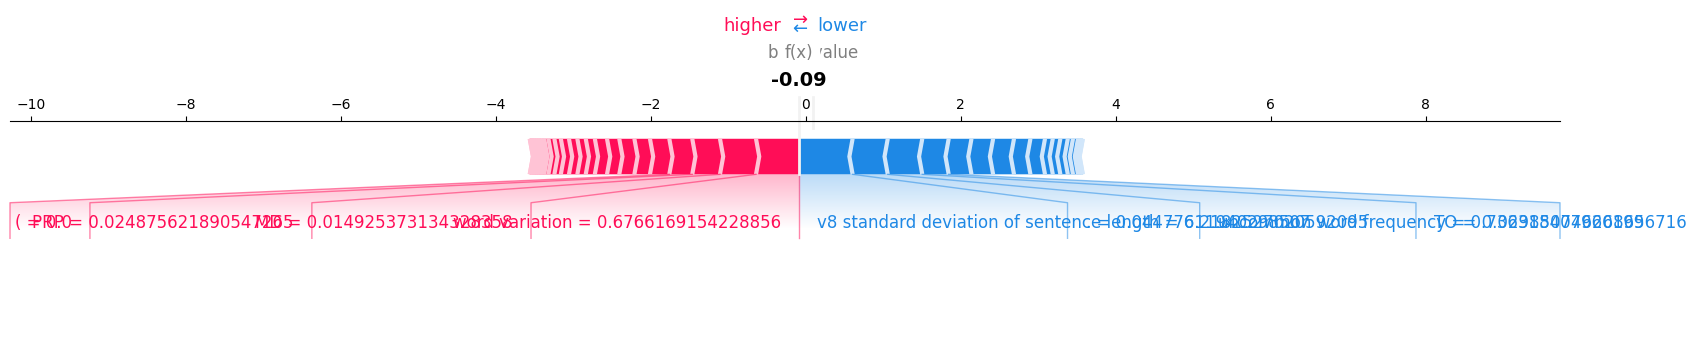

In [56]:
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    matplotlib=True,
    show=False,
)
plt.savefig(
    SHAP_FIGURE_DIR.joinpath("shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

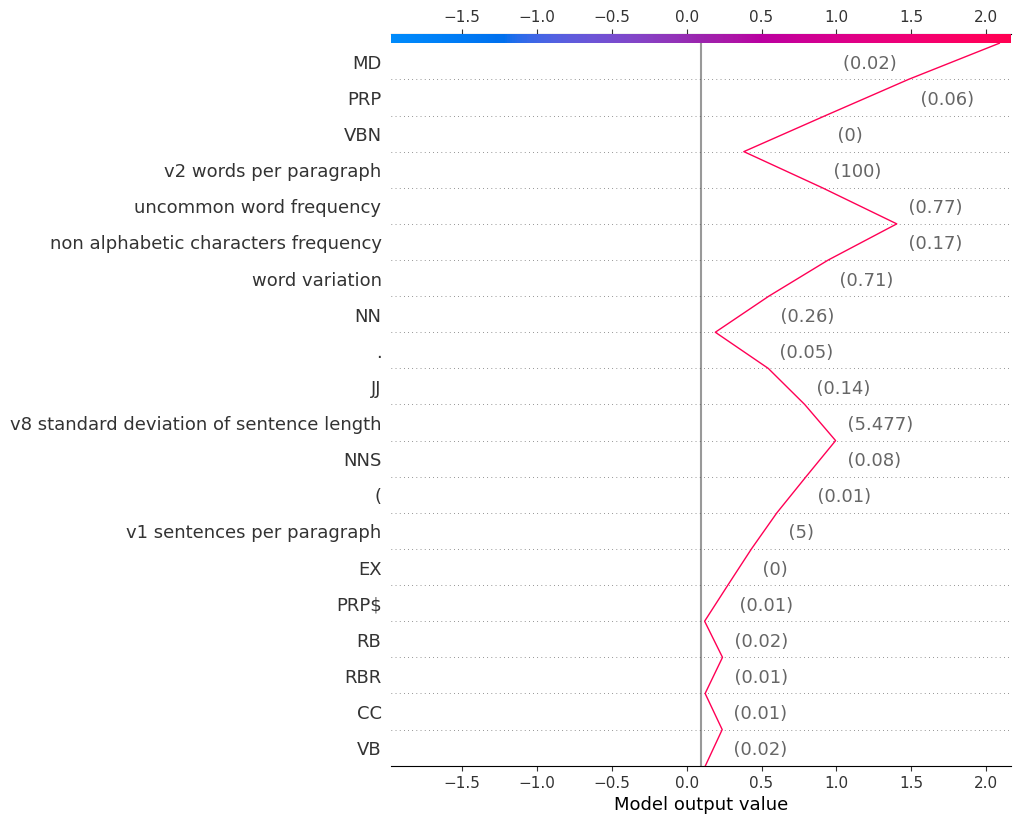

<Figure size 640x480 with 0 Axes>

In [42]:
shap.decision_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    show=False,
)
plt.savefig(
    SHAP_FIGURE_DIR.joinpath("shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

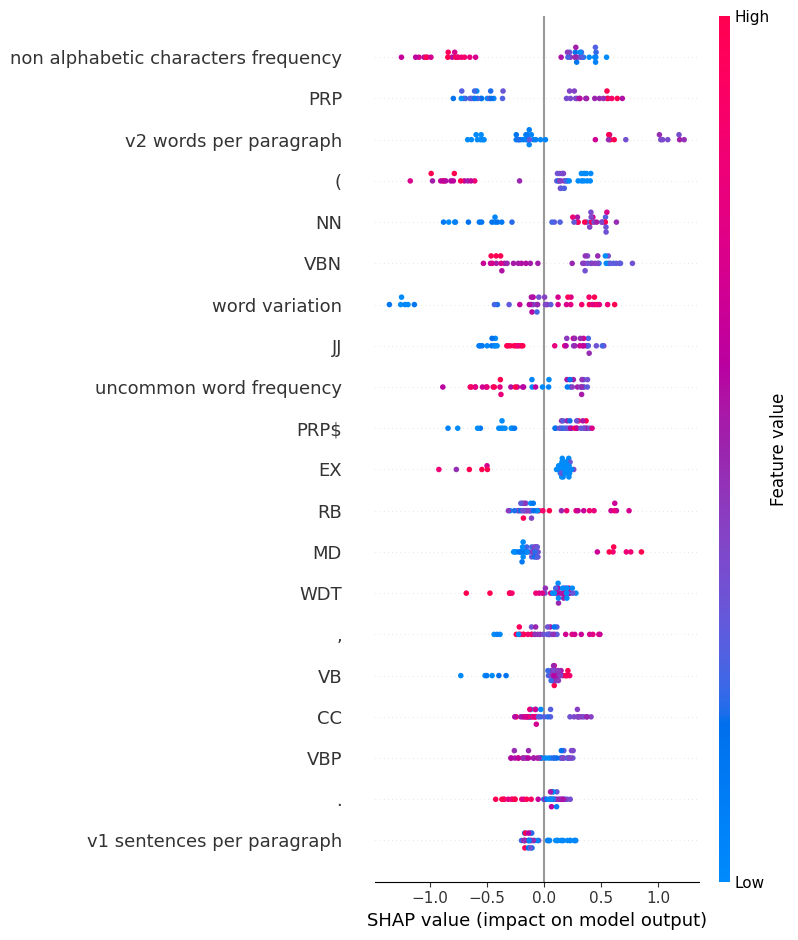

<Figure size 640x480 with 0 Axes>

In [43]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.savefig(
    SHAP_FIGURE_DIR.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

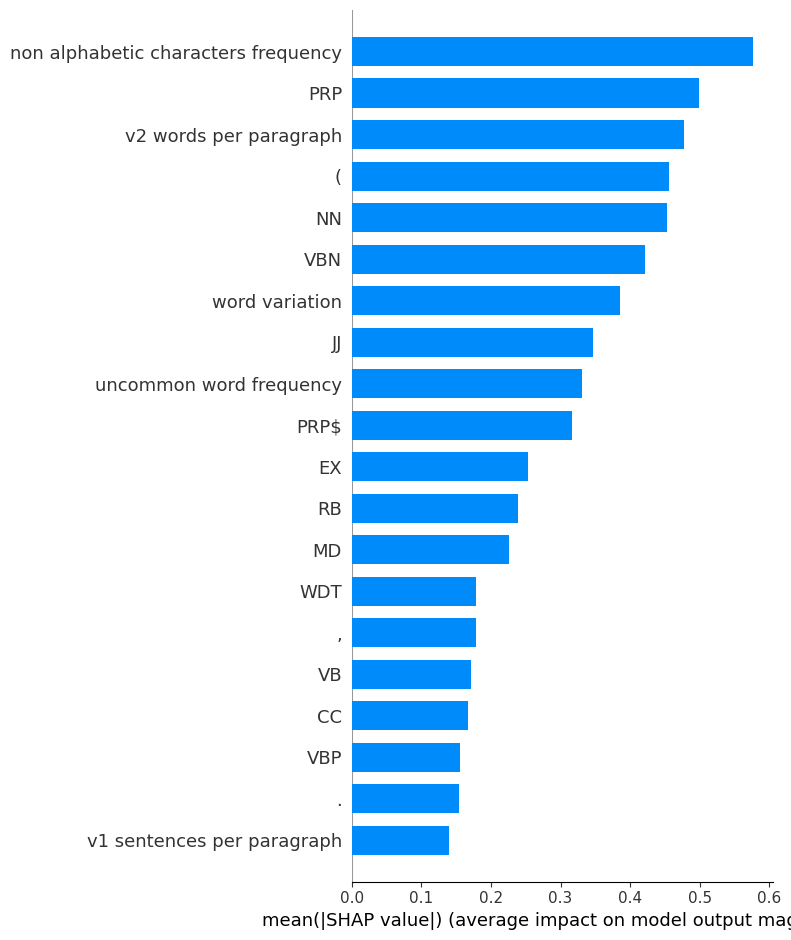

<Figure size 640x480 with 0 Axes>

In [44]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    SHAP_FIGURE_DIR.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

In [45]:
results_for_each_iters: list[TrainingResult] = cv_trainer.train_loocv(source)

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2311
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2311
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarr

[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2320
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [46]:
cv_result: CrossValidationResult = cv_trainer.convert_results_to_cv_result(
    results_for_each_iters
)

In [47]:
cv_global_exp_data: CvGlobalExplanationData = (
    cv_trainer.convert_cv_result_to_global_exp_data(cv_result)
)

In [48]:
cv_score: Score = cv_trainer.calc_score_for_cv(cv_global_exp_data)

In [49]:
if cv_score is not None:
    print(f"auc-roc score: {cv_score.auc_roc_score}")
    print(f"f1 score: {cv_score.f1_score}")
    print(f"accuracy score: {cv_score.accuracy_score}")

auc-roc score: 0.7021999999999999
f1 score: 0.6368159203980099
accuracy score: 0.635


In [50]:
display(pred_crosstab(cv_global_exp_data.test_ans, cv_global_exp_data.pred_ans))

predicted,False,True
actual,,
False,63,37
True,36,64


In [51]:
test_data = cv_global_exp_data.test_data
shap_vals = cv_global_exp_data.shap_vals

In [52]:
shap.initjs()

In [53]:
vijini_loocv_figure_dir_path = VijiniDatasetLoocvPaths.shap_figure_dir

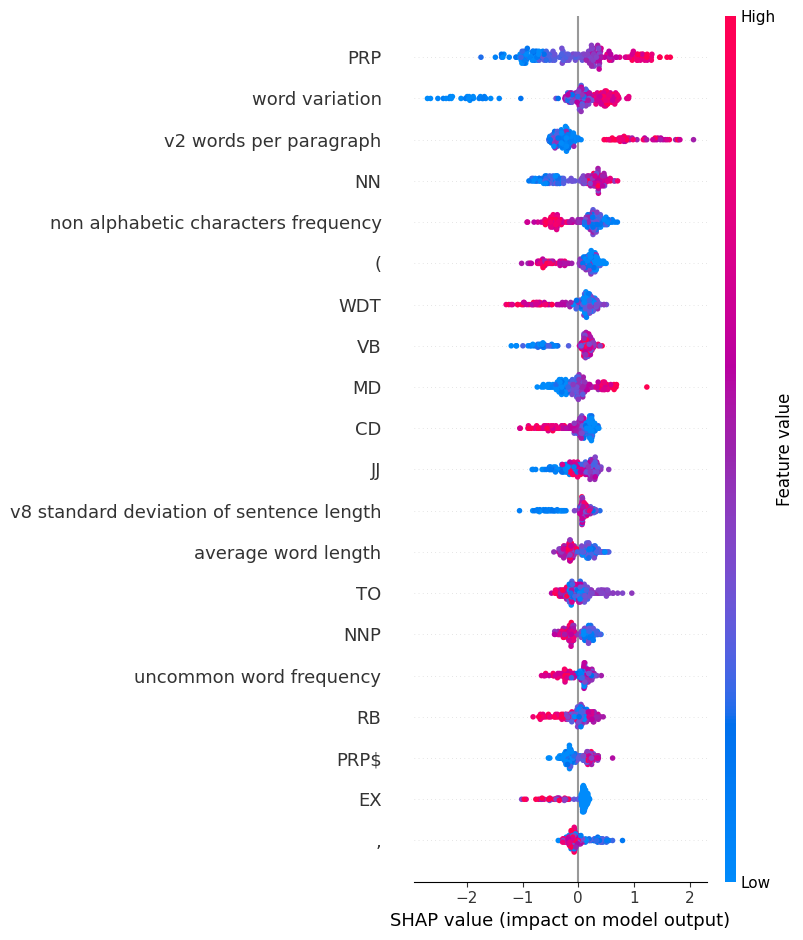

<Figure size 640x480 with 0 Axes>

In [54]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.savefig(
    vijini_loocv_figure_dir_path.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

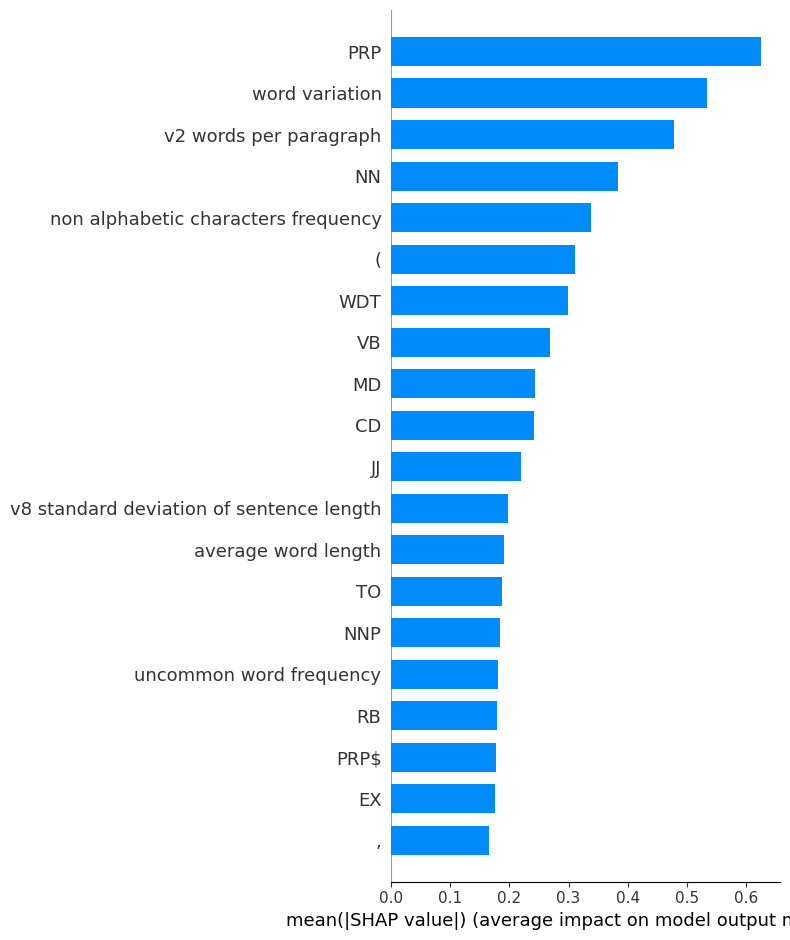

<Figure size 640x480 with 0 Axes>

In [55]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)

plt.savefig(
    vijini_loocv_figure_dir_path.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()